# Packages

In [1]:
using Pkg; Pkg.activate("."); 
using PyPlot
using LaTeXStrings
using NetCDF
using MUST
using StatsBase
using TSO
using DelimitedFiles

MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2";

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/Muram/Project.toml`


# Reading the Muram models in the orginial format

Location of the model

In [2]:
model_name = "cube_small.221000"
model_path = "models/HD/HD_set1/$(model_name).nc";

Read the content

In [3]:
U  = ncread(model_path, "U")
W  = ncread(model_path, "W")
T  = ncread(model_path, "T")
P  = ncread(model_path, "P")
By = ncread(model_path, "By")
V  = ncread(model_path, "V")
Bx = ncread(model_path, "Bx")
R  = ncread(model_path, "R")
E  = ncread(model_path, "E")
Bz = ncread(model_path, "Bz");

In [4]:
s = size(U);

Read the spacing

In [5]:
dx = ncgetatt(model_path, "Global", "dx")
dy = ncgetatt(model_path, "Global", "dy")
dz = ncgetatt(model_path, "Global", "dz");

Parameters

In [6]:
time  = ncgetatt(model_path, "Global", "time")
paras = MUST.AtmosphericParameters() 
paras.time = time;

# Convert

Convert it to the `MUST.jl` representation. It is already boxed, so it can be read directly as a box.

In [7]:
x = range(-(s[1]-1) * dx/2,   step=dx, length=s[1])
y = range(-(s[2]-1) * dy/2,   step=dy, length=s[2])
z = -range(-(s[3]-1) * dz*1/2, step=dz, length=s[3]);

In [8]:
xx, yy, zz = MUST.meshgrid(x, y, z);

In [9]:
data = Dict{Symbol, Array{eltype(U), 3}}(   :ux  => U ,
                                            :uz  => W ,
                                            :T   => T ,
                                            :P   => P ,
                                            :By  => By,
                                            :uy  => V ,
                                            :Bx  => Bx,
                                            :d   => R ,
                                            :E   => E ,
                                            :Bz  => Bz );

In [10]:
b = MUST.Box(xx, yy, zz, data, paras);

# Look at the final cube

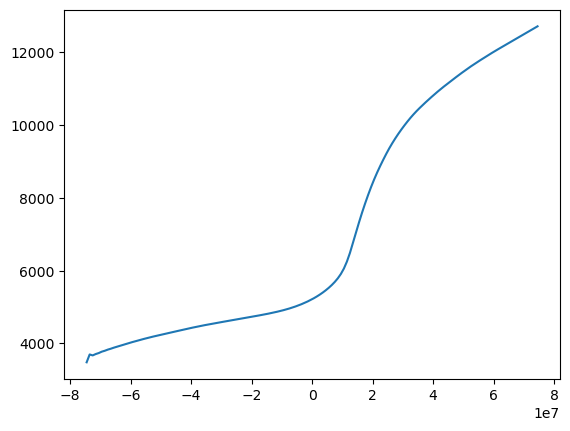

In [11]:
close()

d = MUST.plane_statistic(mean, b, :T)
z = MUST.axis(b, :z)

plt.plot(z, d)

gcf()

# Optical depth

Load an EoS (on the T grid is most convenient)

In [12]:
eos_path = "/u/peitner/Turbospectrum/opacity_tables/tests/DIS_MARCS_v0.4.4/"
eos      = reload(SqEoS, joinpath(eos_path, "eos.hdf5"));

In [13]:
b.data[:kr] = exp.(lookup(eos, :lnRoss, log.(b[:d]), log.(b[:T])));

In [14]:
τ = MUST.optical_depth(b, opacity=:kr, density=:d);

In [15]:
b.data[:τ_ross] = τ;

Interpolate the cube to the new height scale, based on the optical depth

In [16]:
#b_t = MUST.height_scale(b, :τ_ross);

In [17]:
#b_t2 = MUST.height_scale(b, :τ_ross);
b_t2 = MUST.Box("box_tau_MURaM_$(model_name)", folder="");

In [18]:
zt, dt = readdlm("tau_test")[:,1], readdlm("tau_test")[:,2];

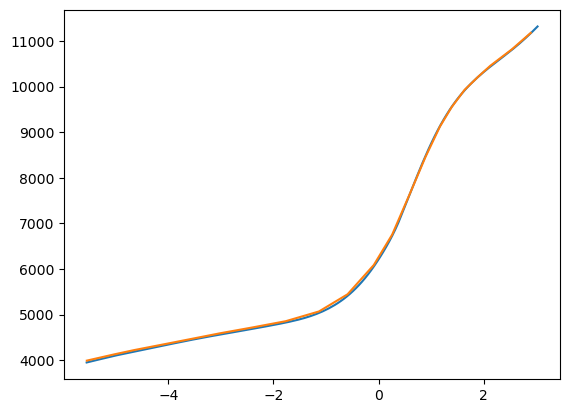

In [19]:
close()

z = log10.(MUST.axis(b_t2, :τ_ross, 3))
d = MUST.plane_statistic(mean, b_t2, :T)

plt.plot(z, d)
plt.plot(zt, dt)


gcf()

In [35]:
tau_surface = MUST.interpolate_to(b_t2, :T, τ_ross=1.0);

Box([-4.4912109375e8 -4.4912109375e8 … -4.4912109375e8 -4.4912109375e8; -4.4736328125e8 -4.4736328124999994e8 … -4.4736328125e8 -4.4736328125e8; … ; 4.4736328125e8 4.4736328125e8 … 4.4736328125e8 4.4736328125e8; 4.4912109375e8 4.4912109375e8 … 4.4912109375e8 4.4912109375e8], [-4.4912109375e8 -4.4736328125e8 … 4.4736328124999994e8 4.4912109375e8; -4.4912109375e8 -4.4736328124999994e8 … 4.4736328125e8 4.4912109375e8; … ; -4.4912109375e8 -4.4736328125e8 … 4.4736328125e8 4.4912109375e8; -4.4912109375e8 -4.4736328125e8 … 4.4736328125e8 4.4912109375e8], [2.503273827839435e7 2.5342102137525953e7 … 2.2597805551082533e7 2.377148558574002e7; 2.4766002904723395e7 2.484482502305208e7 … 2.304272285427109e7 2.395106228706917e7; … ; 2.306298432800187e7 2.4586020957491964e7 … 2.1708033950578913e7 2.2061401206798755e7; 2.4460144882240843e7 2.5750717185791038e7 … 2.1854066241396375e7 2.2883675350007847e7], Dict{Symbol, Array{var"#s11", 3} where var"#s11"<:Union{Float32, Float64, Int16, Int32, Int64}}(:T

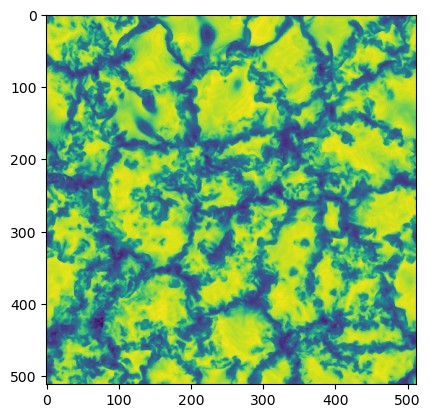

In [38]:
close()
plt.imshow(tau_surface[:T][:,:,1])
gcf()

# Save the model

In [22]:
#MUST.save(b, name="box_MURaM_$(model_name)", folder="")
#MUST.save(b_t2, name="box_tau_MURaM_$(model_name)", folder="")